# Spectral density as a function of $4t$ for fixed $\mu$ #

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import h5py
import numpy as np
import class_utils as class_utils
from class_grid import Grid
from class_params import Params
from class_groundstate import groundstate
from class_excitations import excitations
from class_vertices import vertices
from class_perturbation import perturbative
from class_self_energy import Self_Energy
from class_io import IO
from class_plotting import plot2D, plot_cns, plot_omega0
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker


### For different hopping values

In [2]:
config_path = "config.yml" 

muU = 0.41#np.sqrt(2) - 1 # which chemical potential we are fixing to

output_dir = class_utils.create_output_dir()
config = class_utils.read_config(config_path)

Lx = config["grid"]["Lx"]
Ly = config["grid"]["Ly"]
cutoff = config["physics"]["cutoff"]
N = config["physics"]["N"]
UIB = config["physics"]["UIB"]
M = Lx * Ly

grid = Grid(Lx, Ly)

num_en = 100 # 100 gets pretty good resolution.  takes at least an hour then.
num_dJU = 100 # 100
dJU_max = 0.5
en_vector = np.linspace(0.001, 0.5, num_en)#0.001,0.5,num_en) #0.001, 0.5,num_en)
dJUs = np.linspace(0, dJU_max, num_dJU)

In [3]:
omega0s = np.zeros(len(dJUs))
omega1s = np.zeros(len(dJUs))
omega2s = np.zeros(len(dJUs))

SE = np.zeros((7, len(en_vector)), dtype=np.complex128)  #7 rows for each contribution, num_en columns ##V: why 7?


#V:  Add poles to this plot!!!
T11 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T12 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T21 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T22 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T22_F = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
SE_SI = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)

for count, dJU in enumerate(dJUs):
    print(count,dJU)
    params = Params(N, dJU, muU, UIB, cutoff)
    gs = groundstate(params)
    cns = gs.cns()
    n0 = gs.n0(cns)
    psi0 = gs.psi0(cns)
    exc = excitations(grid, params, gs, cns)
    uks, vks, omegaklambda = exc.calculate_matrices()
    verts = vertices(grid, gs, uks, vks, cns, n0)
    pert = perturbative(grid, params, verts, omegaklambda)
    Pert_Energy = pert.perturbative_energy(n0)
    omega0s[count] = Pert_Energy[0]
    omega1s[count] = Pert_Energy[1]
    omega2s[count] = Pert_Energy[2]

    for epol_ind in range(len(en_vector)):
        Epol = en_vector[epol_ind]
        self_energy = Self_Energy(Epol, grid, params, verts, omegaklambda)
        output = self_energy.calculate_self_energy() # diagrammatic resummation
        #output = self_energy.calculate_self_energy_perturbative() # perturbative result
        SE[:, epol_ind] = output
    #The zeroth element is the full self energy minus w, used for finding the zero crossings.
    T11[count, :] = SE[1, :]
    T12[count, :] = SE[2, :]
    T21[count, :] = SE[3, :]
    T22[count, :] = SE[4, :]
    T22_F[count, :] = SE[5, :]
    SE_SI[count, :] = SE[6, :]

0 0.0
1 0.005050505050505051
2 0.010101010101010102
3 0.015151515151515152
4 0.020202020202020204
5 0.025252525252525256
6 0.030303030303030304
7 0.03535353535353536
8 0.04040404040404041
9 0.045454545454545456
10 0.05050505050505051
11 0.05555555555555556
12 0.06060606060606061
13 0.06565656565656566
14 0.07070707070707072
15 0.07575757575757576
16 0.08080808080808081
17 0.08585858585858587
18 0.09090909090909091
19 0.09595959595959597
20 0.10101010101010102
21 0.10606060606060606
22 0.11111111111111112
23 0.11616161616161617
24 0.12121212121212122
25 0.12626262626262627
26 0.13131313131313133
27 0.13636363636363638
28 0.14141414141414144
29 0.14646464646464646
30 0.15151515151515152
31 0.15656565656565657
32 0.16161616161616163
33 0.16666666666666669
34 0.17171717171717174
35 0.1767676767676768
36 0.18181818181818182
37 0.18686868686868688
38 0.19191919191919193
39 0.196969696969697
40 0.20202020202020204
41 0.2070707070707071
42 0.21212121212121213
43 0.21717171717171718
44 0.222222

In [9]:
# construct the spectral function and T-matrices 
SpectralFuncs = np.zeros((len(dJUs), len(en_vector)))
TFuncs = np.zeros((len(dJUs), len(en_vector)),dtype=np.complex128)
dOmega = en_vector[1] - en_vector[0]
eta = 0.01  #0.01# this is a huge eta.  why?

#
for count in range(0, len(dJUs)):
    #SE_SI[count] = T11[count] + T12[count] + T21[count] + T22[count] + T22_F[count] 
    SpectralFuncs[count, :] = dOmega * (-2) * np.imag(1./(en_vector - SE_SI[count] + 1j * eta))
    TFuncs[count, :] = T11[count] + T12[count] + T21[count] + T22[count] + T22_F[count] 

# find position of T-matrix poles
pol_w = np.zeros(len(dJUs))
                 
for count in range(0, len(dJUs)):
    pol_w[count] = None #en_vector[ np.argmax(TFuncs[count,:]) ] 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


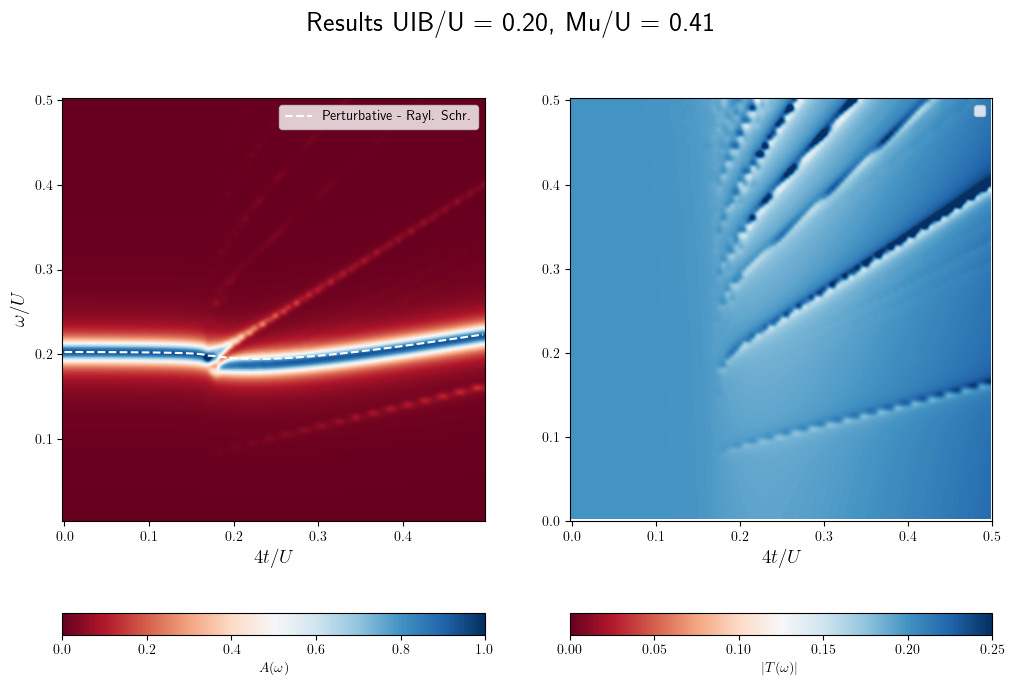

In [24]:
plt.rcParams['text.usetex'] = True

threshold = 0.00

filtered_SpectralFuncs = np.where(abs(SpectralFuncs) > threshold, SpectralFuncs, 0)


# Rotate the image by -90 degrees
SpectralFuncs_rot = np.rot90(filtered_SpectralFuncs, 1)
TFuncs_rot = np.rot90(TFuncs, 1)


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,8))

# Create the plot
# Set the aspect ratio to the ratio of the number of x points to the number of y points
aspect_ratio = 1
im1 = ax1.imshow(SpectralFuncs_rot, interpolation = 'bicubic', cmap='RdBu', aspect = aspect_ratio,label = "hey")
im2 = ax2.imshow(np.abs(TFuncs_rot), interpolation = 'bicubic',cmap='RdBu', aspect = aspect_ratio)

# Select a subset of dJUs and en_vector for the ticks
num_xticks = 6
num_yticks = 6

xticks = np.linspace(0, SpectralFuncs_rot.shape[1], num_xticks, endpoint=True, dtype=int)
yticks = np.linspace(0, SpectralFuncs_rot.shape[0], num_yticks, endpoint=True, dtype=int)

xticklabels = np.round(np.linspace(min(dJUs), max(dJUs), num_xticks), 2)
yticklabels = np.round(np.linspace(max(en_vector), min(en_vector), num_yticks), 2)

# Format the labels in LaTeX
xticklabels = [r'$\mathrm{{{}}}$'.format(label) for label in xticklabels]
yticklabels = [r'$\mathrm{{{}}}$'.format(label) for label in yticklabels]

ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax1.set_xticklabels(xticklabels)
ax1.set_yticklabels(yticklabels)
ax2.set_xticklabels(xticklabels)
ax2.set_yticklabels(yticklabels)
ax1.set_xlabel(r'$4t/U$', fontsize=14)
ax2.set_xlabel(r'$4t/U$', fontsize=14)
ax1.set_ylabel(r'$\omega/U$', fontsize=14)

cb1 = plt.colorbar(im1,orientation="horizontal", label = "$A(\omega)$")
cb2 = plt.colorbar(im2,orientation="horizontal", label = "$|T(\omega)|$")
im1.set_clim(0, 1)
im2.set_clim(0, 0.25)



X, Y = np.meshgrid(dJUs, omega0s + omega1s + omega2s)
# ax2 = ax.twinx()
# Transform the y-coordinates of the plot to match the image coordinates
plot_x = np.interp(dJUs, (dJUs.min(), dJUs.max()), (0, SpectralFuncs_rot.shape[1]-1))
plot_y = SpectralFuncs_rot.shape[0] - 1 - np.interp(omega0s + omega1s + omega2s, (en_vector.min(), en_vector.max()), (0, SpectralFuncs_rot.shape[0]-1))
plot_y_pole = SpectralFuncs_rot.shape[0] - 1 - np.interp(pol_w, (en_vector.min(), en_vector.max()), (0, SpectralFuncs_rot.shape[0]-1))


# Overlay the plot on top of the imshow figure
ax1.plot(plot_x, plot_y, linestyle='--', label='Perturbative - Rayl. Schr.', color='white', linewidth=1.5)
#ax1.plot(plot_x[20:-1], plot_y_pole[20:-1], linestyle = ':', label='Lowest Pole T-matrix', color='green', linewidth=2)
#ax2.plot(plot_x[20:-1], plot_y_pole[20:-1], linestyle = ':', label='Lowest Pole T-matrix', color='green', linewidth=2)
ax1.legend()
ax2.legend()
fig.suptitle(f"Results UIB/U = {UIB:0.2f}, Mu/U = {muU:0.2f}", fontsize = 20)
plt.show()

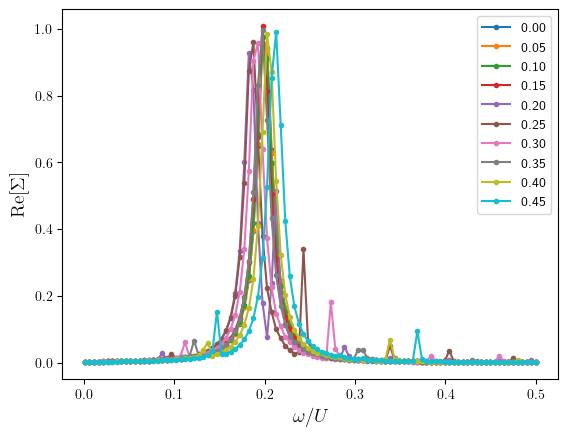

In [14]:
ind_list = range(0,num_dJU,10)
for ind in ind_list:
    plt.plot(en_vector,SpectralFuncs[ind,:],'.-',label = f"{dJUs[ind]:0.2f}")
plt.legend()
plt.xlabel(r'$\omega/U$', fontsize=14)
plt.ylabel(r'$\mathrm{Re}[\Sigma]$', fontsize=14)
#plt.yscale("log")
plt.show()

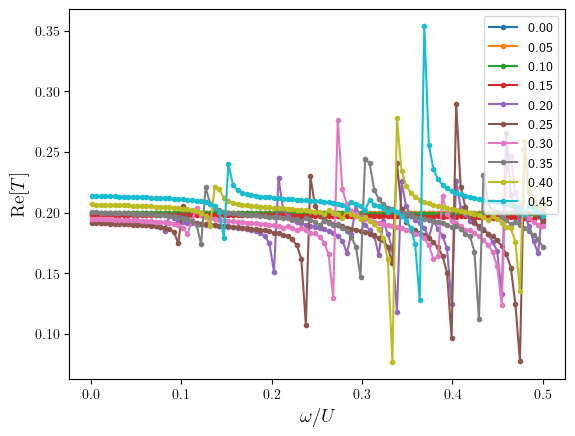

In [15]:
ind_list = range(0,num_dJU,10)
for ind in ind_list:
    plt.plot(en_vector,np.real(TFuncs[ind,:]),'.-',label = f"{dJUs[ind]:0.2f}")
plt.legend()
plt.xlabel(r'$\omega/U$', fontsize=14)
plt.ylabel(r'$\mathrm{Re}[T]$', fontsize=14)
#plt.yscale("log")
plt.show()

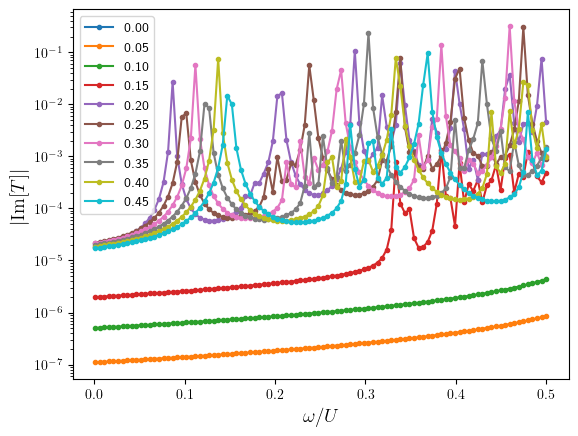

In [16]:
ind_list = range(0,num_dJU,10)
for ind in ind_list:
    plt.plot(en_vector,np.abs(np.imag(TFuncs[ind,:])),'.-',label = f"{dJUs[ind]:0.2f}")
plt.legend()
plt.xlabel(r'$\omega/U$', fontsize=14)
plt.ylabel(r'$|\mathrm{Im}[T]|$', fontsize=14)
plt.yscale("log")
plt.show()

In [25]:
## Save the figure 
filename = f'../figs/Spectral_Line_dJU_Scan_Fixed_Mu/UIB_{UIB}_Mu_{muU:.2f}_M_{grid.M}_N_{N}_num_en_{num_en}_num_dJU_{num_dJU}_dJU_max_{dJU_max}.pdf'
fig.savefig(filename, dpi=300, bbox_inches='tight')

In [18]:
# Save the data

# Code to save results for different UIBs
filename = f'./data/Spectral_Line_dJU_Scan_Fixed_Mu/UIB_{UIB}_Mu_{muU:.2f}_M_{grid.M}_N_{N}_num_en_{num_en}_num_dJU_{num_dJU}_dJU_max_{dJU_max}.hdf5'

with h5py.File(filename, 'w') as f:
    f.create_dataset('UIBs', data=dJUs)
    f.create_dataset('en_vector', data=en_vector)
    f.create_dataset('omega0s', data=omega0s)
    f.create_dataset('omega1s', data=omega1s)
    f.create_dataset('omega2s', data=omega2s)
    for i, dJU in enumerate(dJUs):
    # Create a group for this dJU value
        group = f.create_group(f'dJU_{dJU}')

        # Store the arrays in this group
        group.create_dataset('T11', data=T11[i, :])
        group.create_dataset('T12', data=T12[i, :])
        group.create_dataset('T21', data=T21[i, :])
        group.create_dataset('T22', data=T22[i, :])
        group.create_dataset('T22_SE', data=T22_F[i, :])
        group.create_dataset('SE_SI', data=SE_SI[i, :])
    

    # Create attributes for your parameters
    f.attrs['UIB'] = UIB
    f.attrs['muU'] = muU
    f.attrs['Lx'] = grid.Lx
    f.attrs['Ly'] = grid.Ly
    f.attrs['N'] = N


    UIBs = f['UIBs'][:]
    en_vector = f['en_vector'][:]
    omega0s = f['omega0s'][:]
    omega1s = f['omega1s'][:]
    omega2s = f['omega2s'][:]

    T11 = []
    T12 = []
    T21 = []
    T22 = []
    T22_SE = []
    SE_SI = []

    for count, dJU in enumerate(dJUs):
        group = f[f'dJU_{dJU}']
        T11.append(group['T11'][:])
        T12.append(group['T12'][:])
        T21.append(group['T21'][:])
        T22.append(group['T22'][:])
        T22_SE.append(group['T22_SE'][:])
        SE_SI.append(group['SE_SI'][:])